#**Object Detection**#


#*R-CNN*#

Одним из первых подходов, применимых для определения нахождения объекта на картинке, является R-CNN (Region Convolution Neural Network).
Архитектура состоит из нескольких шагов:
 - Определение набора гипотез.
 - Извлечение из предполагаемых регионов признаков с помощью сверточной нейронной сети и их кодирование в вектор.
 - Классификация объекта внутри гипотезы на основе вектора из шага 2.
 - Улучшение (корректировка) координат гипотезы.
 - Все повторяется, начиная с шага 2, пока не будут обработаны все гипотезы с шага 1.






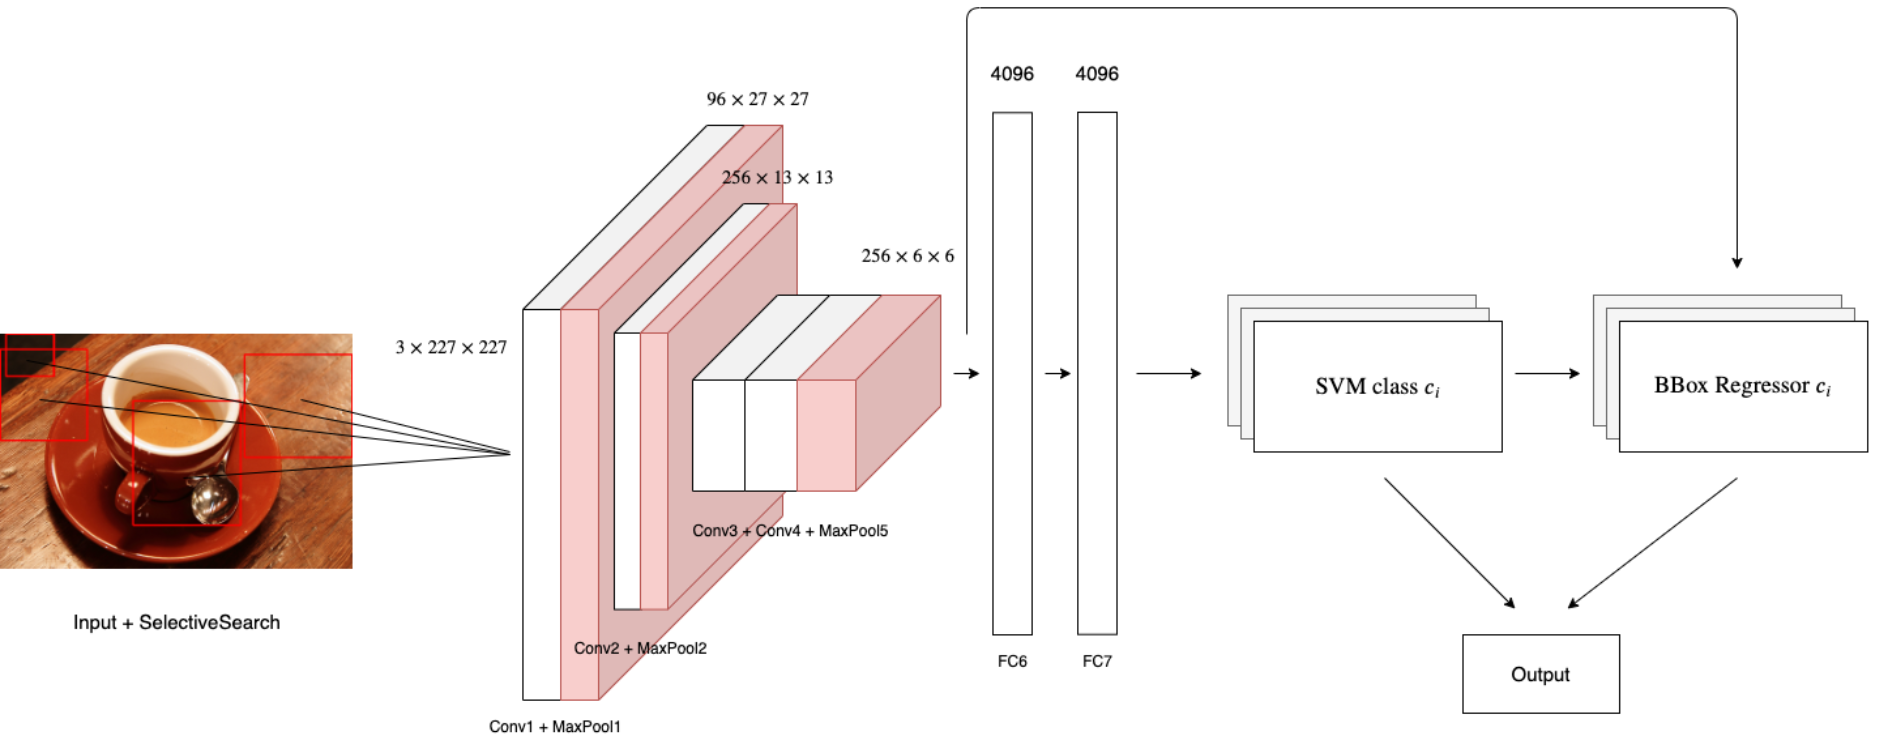

##**Терминология**##

- Ограничивающая рамка (bounding box) – координаты, ограничивающие определенную область изображения, – чаще всего в форме прямоугольника. Может быть представлена 4 координатами в двух форматах: центрированный ($c_{x},c_{y},w,h$) и обычный ($x_{min},y_{min},x_{max},y_{max}$).

- Гипотеза (Proposal), P – определенный регион изображения (заданный с помощью ограничивающей рамки), в котором предположительно находится объект.

- End-to-end обучение – обучение, при котором на вход сети поступают сырые изображения, а на выходе – готовые ответы.

- IoU (Intersection-over-Union) – метрика степени пересечения между двумя ограничивающими рамками. Гипотезы, содержащие объекты, будем называть позитивными (positive), а без объектов (содержащие только фон, или незначительную часть объекта) – негативными (negative).

Для того, чтобы в последующем определить пересечения между двумя регионами изображения будет использоваться метрика Intersection over Union. Она считается довольно просто: площадь пересечения двух областей делится на общую площадь регионов.

С позитивными гипотезами все понятно – если класс определен неверно, нужно штрафовать. Но как быть с негативными? Их намного больше, чем позитивных… Для начала отметим, что не все негативные гипотезы одинаково сложно распознавать. Например, случаи, содержащие только фон (easy negative) гораздо проще классифицировать, чем содержащие другой объект или малую часть нужного (hard negative).

На практике easy negative и hard negative определяются по пересечению ограничивающей рамки (как раз используется Intersection over Union) с правильным положением объекта на изображении. Например, если пересечения нет, или оно крайне мало – это easy negative ($C_{i}=0$), если большое – это hard negative или positive.

Подход Hard Negative Mining предлагает использовать для обучения только hard negative, поскольку, научившись распознавать их, мы автоматический добиваемся наилучшей работы с easy negative гипотезами. Но такая идеология будет применяться только в последующих реализациях (начиная с Fast R-CNN).



#*Object Detection. Square Detection*#

#Libs#

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import json
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
import torchvision.transforms as T
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/square_circle/images

032372ac-image_90.png  3593a0e6-image_37.png  8ca6ddcb-image_89.png  bd2f65ca-image_29.png
04d4c453-image_96.png  3665c244-image_57.png  90a58470-image_62.png  c0a434eb-image_67.png
05f21322-image_95.png  36d597f4-image_43.png  917709c1-image_35.png  c4522b36-image_48.png
0c7f2171-image_4.png   394fbe94-image_36.png  9376a2a5-image_10.png  c5d8352d-image_53.png
0cf0d336-image_26.png  3a46c6cf-image_87.png  948ec751-image_9.png   c8d303ec-image_75.png
0e113e92-image_0.png   3b0b5c56-image_80.png  97c468dd-image_5.png   c98bed1a-image_16.png
0e78751f-image_82.png  4dd455b0-image_93.png  9932f8f9-image_30.png  c9a4c2fe-image_91.png
104c54d3-image_47.png  535a76cc-image_73.png  99e45c05-image_14.png  cb8a7390-image_24.png
11f12e4b-image_79.png  55a0a4ee-image_15.png  9d78ea7d-image_17.png  cd301acc-image_20.png
127346e3-image_31.png  589f8214-image_94.png  9f2f17d8-image_56.png  d1826ac6-image_45.png
137e0909-image_22.png  5c7d09b1-image_18.png  a045838f-image_7.png   d2e4dd4f-image_86.png

In [5]:
def load_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
    transforms.ToTensor()
        ])
    image_tensor = transform(image)
    # Просмотр информации
    print("Размерность тензора изображения:", image_tensor.size())
    print("Ширина изображения:", image_tensor.size(2))
    print("Высота изображения:", image_tensor.size(1))
    print("Количество каналов:", image_tensor.size(0))


image_path = '/content/drive/MyDrive/square_circle/images/9932f8f9-image_30.png'
load_image(image_path)

Размерность тензора изображения: torch.Size([1, 32, 32])
Ширина изображения: 32
Высота изображения: 32
Количество каналов: 1


#Dataset#

In [6]:
class SquareDataset(Dataset):
    def __init__(self, images_folder, annotations_file, transform=None):
        self.images_folder = images_folder
        self.annotations = json.load(open(annotations_file))
        self.transform = transform

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        img_info = self.annotations['images'][idx]
        img_name = os.path.join(self.images_folder, img_info['file_name'])
        image = Image.open(img_name)

        boxes = []
        labels = []
        for annotation in self.annotations['annotations']:
            if annotation['image_id'] == img_info['id'] and annotation['category_id'] == 1:  # Фильтруем только квадраты
                boxes.append(annotation['bbox'])  # [x_min, y_min, width, height]
                labels.append(annotation['category_id'])

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)


        target = {
            "boxes": boxes,
            "labels": labels  # Метки категорий
        }

        return image, target

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

In [7]:
def show_dataset_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, target = dataset[i]
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        for box in target['boxes']:
            x_min, y_min, width, height = box
            rect = plt.Rectangle((x_min, y_min), width, height, fill=False, color='red')
            print(box)

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])


dataset = SquareDataset(images_folder='/content/drive/MyDrive/square_circle',
                        annotations_file='/content/drive/MyDrive/square_circle/result.json',
                        transform=transform)

print(transform)

Compose(
    ToTensor()
)


tensor([ 9.4359, 15.5524, 11.4126, 11.0396])
tensor([20.8858, 18.3869, 10.2191,  9.7716])
tensor([ 8.9138, 18.2378, 12.1585, 11.6737])
tensor([18.4714, 10.3250, 12.4090, 12.0774])
tensor([ 8.2411, 19.4660, 12.1721, 12.4090])


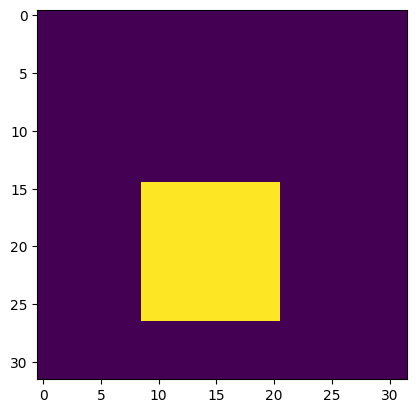

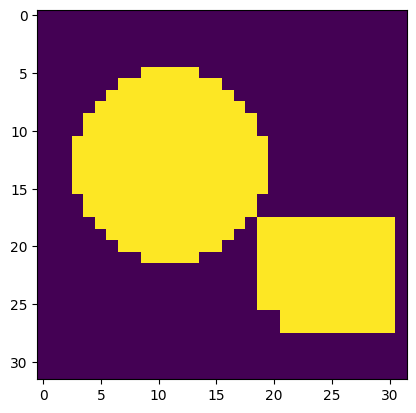

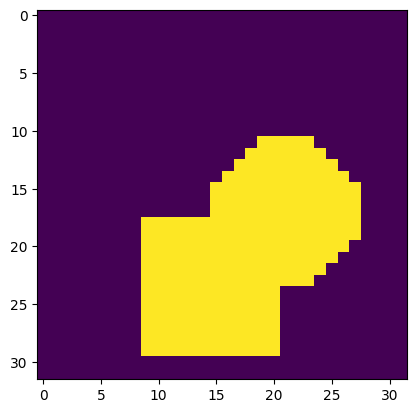

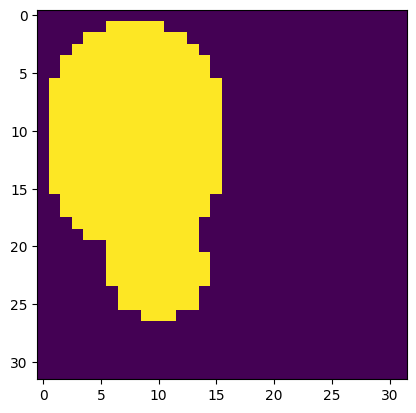

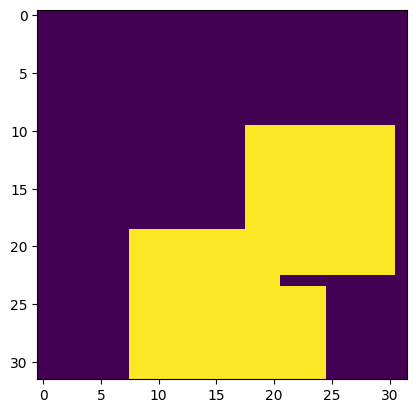

In [9]:
# Отображение первых 5 образцов
show_dataset_samples(dataset, num_samples=5)

In [10]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [11]:
print(len(dataset))

100


In [12]:
for images, targets in dataloader:
    print("Batch of images:", len(images))
    print("Batch of target boxes:", [target["boxes"] for target in targets])
    print("Batch of target labels:", [target["labels"].size() for target in targets])
    break

Batch of images: 4
Batch of target boxes: [tensor([[ 9.3986, 19.8042, 10.3683,  9.8089]]), tensor([[11.8601, 20.2145,  8.9883,  8.3916]]), tensor([[15.8881,  9.3240, 12.8298, 11.1515]]), tensor([[13.1282, 10.1072,  6.4149,  6.6014],
        [21.4825, 20.2890,  8.9883,  9.1002]])]
Batch of target labels: [torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([2])]


In [17]:
def get_model_instance_segmentation(num_classes):

    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


num_classes = 2
model = get_model_instance_segmentation(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [15]:
def check_and_filter_boxes(targets, device=device):
    valid_targets = []
    for t in targets:
        valid_boxes = []
        for box in t['boxes']:
            x_min, y_min, x_max, y_max = box
            if x_max > x_min and y_max > y_min:
                valid_boxes.append(box)
        if valid_boxes:
            valid_boxes_tensor = torch.stack(valid_boxes).to(device)
            valid_targets.append({'boxes': valid_boxes_tensor, 'labels': t['labels'].to(device)})
        else:
            valid_targets.append({'boxes': torch.empty((0, 4), device=device), 'labels': torch.empty(0, dtype=torch.int64, device=device)})
    return valid_targets


# Пример использования функции фильтрации
targets = [
    {'boxes': torch.tensor([[ 7.6084, 12.9417, 12.8671, 10.8904]]), 'labels': torch.tensor([1])},
    {'boxes': torch.tensor([[23.9441, 18.0140,  8.0559,  7.5711]]), 'labels': torch.tensor([1])},
    {'boxes': torch.tensor([[17.9021, 12.0466,  7.0490,  6.9371]]), 'labels': torch.tensor([1])}
]

filtered_targets = check_and_filter_boxes(targets)
print(filtered_targets)


[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64)}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64)}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64)}]


In [18]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)

        targets_gpu = check_and_filter_boxes(targets, device=device)

        loss_dict = model(images, targets_gpu)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:  # Вывод информации о процессе обучения каждые 10 шагов
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {losses.item()}")
        i += 1

    lr_scheduler.step()

print("Training completed.")


Epoch [0/5], Step [0/25], Loss: 1.0635002851486206
Epoch [0/5], Step [10/25], Loss: 1.0934054851531982
Epoch [0/5], Step [20/25], Loss: 1.126736044883728
Epoch [1/5], Step [0/25], Loss: 1.1764968633651733
Epoch [1/5], Step [10/25], Loss: 1.1469261646270752
Epoch [1/5], Step [20/25], Loss: 1.0535591840744019
Epoch [2/5], Step [0/25], Loss: 1.0804369449615479
Epoch [2/5], Step [10/25], Loss: 1.0295826196670532
Epoch [2/5], Step [20/25], Loss: 1.0554938316345215
Epoch [3/5], Step [0/25], Loss: 1.0233180522918701
Epoch [3/5], Step [10/25], Loss: 1.0507092475891113
Epoch [3/5], Step [20/25], Loss: 1.0887715816497803
Epoch [4/5], Step [0/25], Loss: 1.0672417879104614
Epoch [4/5], Step [10/25], Loss: 1.0590178966522217
Epoch [4/5], Step [20/25], Loss: 1.085328221321106
Training completed.


In [19]:
import shutil
# Сохранение модели в файл
torch.save(model.state_dict(), "fasterrcnn_model1.pth")
shutil.move("fasterrcnn_model1.pth", "/content/drive/MyDrive/Square_Object_Detection")

'/content/drive/MyDrive/Square_Object_Detection'

In [20]:
model_path = "/content/drive/MyDrive/Square_Object_Detection/fasterrcnn_model.pth"
model = torch.load(model_path)
model = torch.load(model_path)
model.eval()
#print(loaded_model)

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/Square_Object_Detection/fasterrcnn_model.pth'

#Test#

In [21]:
class TestDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

In [23]:
! ls /content/drive/MyDrive/square_circle_test/images

02f77044-test_image_84.png  5d55705b-test_image_27.png	af9aa8b3-test_image_11.png
0748f028-test_image_35.png  5f43587a-test_image_93.png	b4b77b69-test_image_90.png
08cf28a2-test_image_51.png  5fc9ceac-test_image_2.png	baac27a5-test_image_49.png
0e03bc5a-test_image_62.png  60ecbb5a-test_image_40.png	be313b11-test_image_9.png
0ef51f0a-test_image_71.png  61085123-test_image_60.png	c2b9ff63-test_image_95.png
1184b165-test_image_22.png  6194cae4-test_image_68.png	c366dde5-test_image_82.png
1204e540-test_image_59.png  61967b5f-test_image_73.png	c5958d29-test_image_86.png
126b94d9-test_image_6.png   652e5c3b-test_image_88.png	c643f285-test_image_43.png
1a6f02a7-test_image_5.png   679d8ada-test_image_94.png	c9d366c5-test_image_85.png
203d2fc1-test_image_13.png  68a42605-test_image_78.png	c9fa5b2f-test_image_99.png
23836074-test_image_79.png  6ced8d6a-test_image_65.png	ca5848bf-test_image_54.png
268fb83a-test_image_76.png  6d77cfe6-test_image_29.png	ccd082fd-test_image_37.png
26c2ead2-test_imag

In [35]:
test_dataset = TestDataset('/content/drive/MyDrive/square_circle_test/images', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Box coordinates: xmin=19.016517639160156, ymin=0.0, xmax=21.74358558654785, ymax=12.285894393920898
Box coordinates: xmin=3.9972617626190186, ymin=0.0, xmax=7.001380443572998, ymax=13.135285377502441
Box coordinates: xmin=4.779860019683838, ymin=0.0, xmax=7.9066948890686035, ymax=9.753683090209961
Box coordinates: xmin=0.0, ymin=2.6411242485046387, xmax=12.156906127929688, ymax=5.7692155838012695
Box coordinates: xmin=17.70456314086914, ymin=0.0, xmax=20.450557708740234, ymax=9.055874824523926
Box coordinates: xmin=3.2823092937469482, ymin=1.1090692281723022, xmax=8.793521881103516, ymax=7.383893966674805
Box coordinates: xmin=6.096250534057617, ymin=0.0, xmax=9.136795997619629, ymax=8.196157455444336
Box coordinates: xmin=2.8376805782318115, ymin=0.0, xmax=6.144411563873291, ymax=11.666316986083984
Box coordinates: xmin=15.827181816101074, ymin=0.0, xmax=18.67854118347168, ymax=7.557751178741455
Box coordinates: xmin=20.151288986206055, ymin=0.09650085121393204, xmax=22.84117126464843

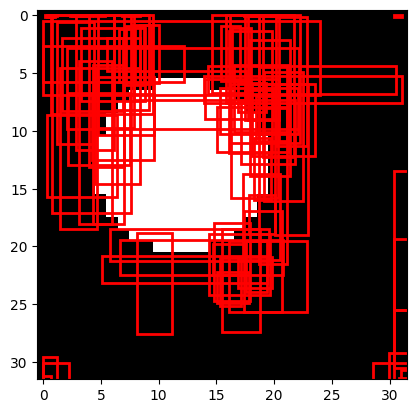

Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=12.59841537475586, ymin=27.28233528137207, xmax=16.081588745117188, ymax=31.914464950561523
Box coordinates: xmin=15.415406227111816, ymin=23.461410522460938, xmax=19.28208351135254, ymax=30.388568878173828
Box coordinates: xmin=30.909149169921875, ymin=29.448705673217773, xmax=32.0, ymax=31.79898452758789
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=31.010093688964844, ymin=30.679012298583984, xmax=32.0, ymax=31.95823097229004
Box coordinates: xmin=6.5710272789001465, ymin=27.998170852661133, xmax=19.095897674560547, ymax=30.799074172973633
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884658813, ymax=31.80974578857422
Box coordinates: xmin=0.0, ymin=27.866262435913086, xmax=10.368325233459473, ymax=30.914840698242188
Box coordinates: xmin=24.03978157043457, ymin=27.2284

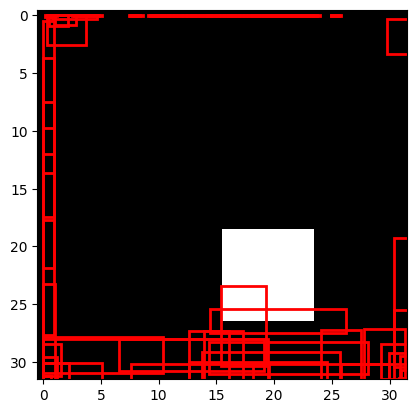

Box coordinates: xmin=5.724115371704102, ymin=3.72202205657959, xmax=8.53426456451416, ymax=18.168432235717773
Box coordinates: xmin=14.385699272155762, ymin=3.353990316390991, xmax=17.508060455322266, ymax=17.131996154785156
Box coordinates: xmin=6.8756842613220215, ymin=3.6036224365234375, xmax=9.739879608154297, ymax=16.246721267700195
Box coordinates: xmin=15.731569290161133, ymin=3.596230983734131, xmax=18.69253921508789, ymax=18.33034896850586
Box coordinates: xmin=13.307474136352539, ymin=3.249605655670166, xmax=16.27897834777832, ymax=16.60715675354004
Box coordinates: xmin=16.923147201538086, ymin=2.553499698638916, xmax=19.577539443969727, ymax=16.98672866821289
Box coordinates: xmin=4.356450080871582, ymin=4.684154987335205, xmax=7.323020935058594, ymax=17.832443237304688
Box coordinates: xmin=7.958677768707275, ymin=4.200106620788574, xmax=11.104310035705566, ymax=15.6056489944458
Box coordinates: xmin=13.608333587646484, ymin=6.976262092590332, xmax=16.850675582885742, yma

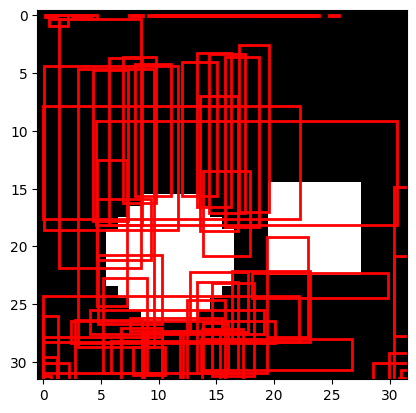

Box coordinates: xmin=13.639580726623535, ymin=22.046722412109375, xmax=17.293508529663086, ymax=29.61842155456543
Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=30.346845626831055, ymin=6.8236236572265625, xmax=32.0, ymax=17.169179916381836
Box coordinates: xmin=30.90898323059082, ymin=29.45804214477539, xmax=32.0, ymax=31.79038429260254
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=31.008562088012695, ymin=30.6807918548584, xmax=32.0, ymax=31.958654403686523
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884658813, ymax=31.80974578857422
Box coordinates: xmin=30.859952926635742, ymin=8.310851097106934, xmax=32.0, ymax=10.783356666564941
Box coordinates: xmin=0.2985723912715912, ymin=27.86213493347168, xmax=11.177518844604492, ymax=30.892833709716797
Box coordinates: xmin=0.7616990208625793, ymin=0.0, xmax=4.6856946945

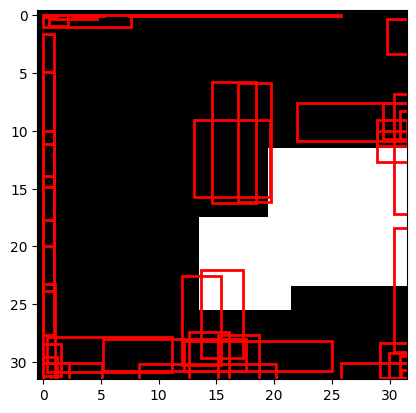

Box coordinates: xmin=11.123783111572266, ymin=6.45286226272583, xmax=14.154017448425293, ymax=24.108489990234375
Box coordinates: xmin=11.86428165435791, ymin=5.418681621551514, xmax=14.87255859375, ymax=20.685287475585938
Box coordinates: xmin=11.407357215881348, ymin=13.374403953552246, xmax=16.311012268066406, ymax=19.584699630737305
Box coordinates: xmin=12.960895538330078, ymin=5.012215614318848, xmax=16.068578720092773, ymax=19.71125030517578
Box coordinates: xmin=10.12508487701416, ymin=7.342280864715576, xmax=13.032576560974121, ymax=22.5371036529541
Box coordinates: xmin=13.882707595825195, ymin=3.487208127975464, xmax=16.731794357299805, ymax=17.702444076538086
Box coordinates: xmin=10.879071235656738, ymin=15.561918258666992, xmax=16.095624923706055, ymax=21.498836517333984
Box coordinates: xmin=27.131195068359375, ymin=3.9318511486053467, xmax=30.366079330444336, ymax=18.15734100341797
Box coordinates: xmin=28.600337982177734, ymin=6.239541053771973, xmax=31.39914321899414

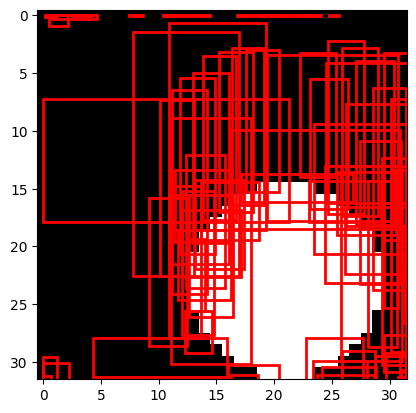

Box coordinates: xmin=16.88802719116211, ymin=21.735164642333984, xmax=20.572277069091797, ymax=29.688329696655273
Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=13.082842826843262, ymin=24.955821990966797, xmax=28.513036727905273, ymax=27.281057357788086
Box coordinates: xmin=30.867549896240234, ymin=28.794137954711914, xmax=32.0, ymax=31.220964431762695
Box coordinates: xmin=28.89327621459961, ymin=29.220048904418945, xmax=31.455379486083984, ymax=31.447397232055664
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=31.009061813354492, ymin=30.67959213256836, xmax=32.0, ymax=31.958019256591797
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884658813, ymax=31.80974578857422
Box coordinates: xmin=0.0, ymin=27.86545753479004, xmax=10.369482040405273, ymax=30.916244506835938
Box coordinates: xmin=0.7616990208625793, ymin=0.0, 

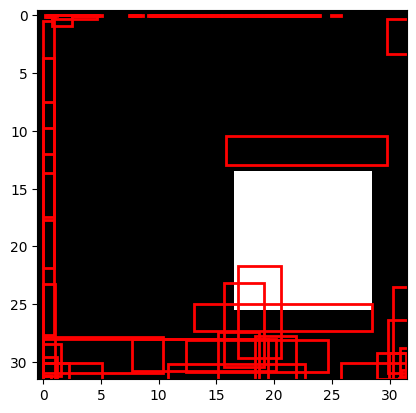

Box coordinates: xmin=0.0, ymin=30.086315155029297, xmax=5.117495059967041, ymax=31.92662239074707
Box coordinates: xmin=17.557397842407227, ymin=8.380425453186035, xmax=20.744415283203125, ymax=19.303674697875977
Box coordinates: xmin=9.261985778808594, ymin=8.607405662536621, xmax=12.54307746887207, ymax=18.749231338500977
Box coordinates: xmin=7.468482494354248, ymin=27.29129409790039, xmax=10.96131706237793, ymax=31.9133243560791
Box coordinates: xmin=16.370563507080078, ymin=8.354924201965332, xmax=19.551448822021484, ymax=18.950735092163086
Box coordinates: xmin=18.934297561645508, ymin=27.302467346191406, xmax=22.475976943969727, ymax=31.89375114440918
Box coordinates: xmin=30.909311294555664, ymin=29.448286056518555, xmax=32.0, ymax=31.799530029296875
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=31.009904861450195, ymin=30.67877197265625, xmax=32.0, ymax=31.958209991455078
Box coordinates: xmin=0.33782

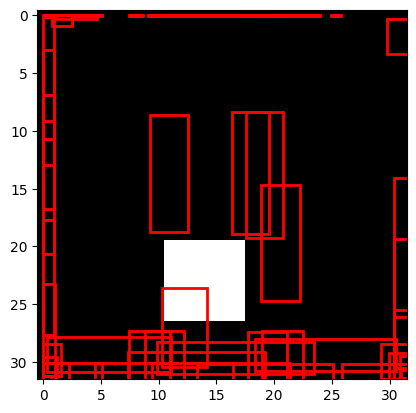

Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=22.97860336303711, ymin=12.45622444152832, xmax=26.766489028930664, ymax=22.65854835510254
Box coordinates: xmin=30.383729934692383, ymin=2.5175464153289795, xmax=32.0, ymax=12.926383018493652
Box coordinates: xmin=13.36050796508789, ymin=15.34008502960205, xmax=27.78764533996582, ymax=18.60569953918457
Box coordinates: xmin=30.332502365112305, ymin=11.107034683227539, xmax=32.0, ymax=21.745248794555664
Box coordinates: xmin=27.913793563842773, ymin=15.520905494689941, xmax=32.0, ymax=18.1450138092041
Box coordinates: xmin=30.909311294555664, ymin=29.448286056518555, xmax=32.0, ymax=31.799530029296875
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=31.009904861450195, ymin=30.67877197265625, xmax=32.0, ymax=31.958209991455078
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884

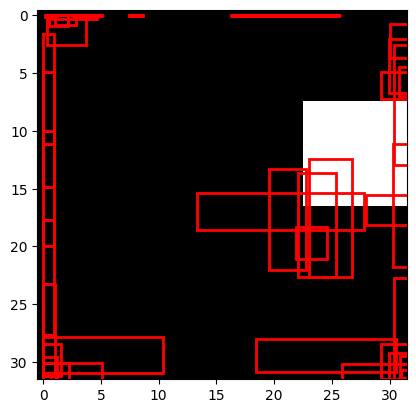

Box coordinates: xmin=17.67372703552246, ymin=2.505735397338867, xmax=20.88886833190918, ymax=16.673154830932617
Box coordinates: xmin=18.91069984436035, ymin=2.462925910949707, xmax=21.941003799438477, ymax=16.90083885192871
Box coordinates: xmin=16.433629989624023, ymin=1.3171954154968262, xmax=19.406190872192383, ymax=12.541918754577637
Box coordinates: xmin=20.835372924804688, ymin=3.9205071926116943, xmax=23.865949630737305, ymax=17.21587371826172
Box coordinates: xmin=5.839875221252441, ymin=0.17049682140350342, xmax=8.56315803527832, ymax=12.0909423828125
Box coordinates: xmin=14.054487228393555, ymin=0.09286010265350342, xmax=16.70830535888672, ymax=11.172916412353516
Box coordinates: xmin=16.03219985961914, ymin=9.746514320373535, xmax=21.453731536865234, ymax=15.905415534973145
Box coordinates: xmin=4.000767230987549, ymin=1.1396948099136353, xmax=7.2820000648498535, ymax=12.94109058380127
Box coordinates: xmin=3.0601024627685547, ymin=1.7692497968673706, xmax=6.1720080375671

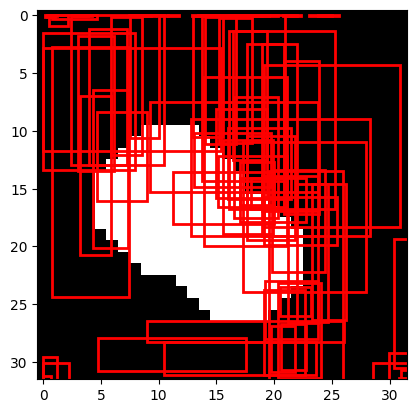

Box coordinates: xmin=22.59078025817871, ymin=2.1672496795654297, xmax=25.498109817504883, ymax=14.941033363342285
Box coordinates: xmin=3.9442596435546875, ymin=0.9941003322601318, xmax=7.058832168579102, ymax=16.26569938659668
Box coordinates: xmin=5.7244133949279785, ymin=0.0, xmax=8.654376983642578, ymax=11.86030101776123
Box coordinates: xmin=4.410796642303467, ymin=5.72343111038208, xmax=9.49748706817627, ymax=11.874544143676758
Box coordinates: xmin=19.93311309814453, ymin=5.870904445648193, xmax=24.915939331054688, ymax=12.02664852142334
Box coordinates: xmin=21.369306564331055, ymin=1.9977771043777466, xmax=24.446752548217773, ymax=16.03488540649414
Box coordinates: xmin=20.96168327331543, ymin=0.06261046975851059, xmax=23.96735382080078, ymax=11.116293907165527
Box coordinates: xmin=19.138065338134766, ymin=0.006367492489516735, xmax=21.876605987548828, ymax=9.442919731140137
Box coordinates: xmin=7.523150444030762, ymin=0.0, xmax=10.35399055480957, ymax=9.633012771606445
Box

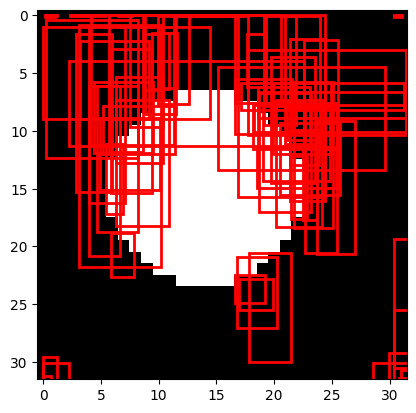

Box coordinates: xmin=0.0, ymin=30.07915496826172, xmax=5.1171488761901855, ymax=31.915599822998047
Box coordinates: xmin=20.154478073120117, ymin=9.66500186920166, xmax=23.29671287536621, ymax=20.332378387451172
Box coordinates: xmin=30.909311294555664, ymin=29.448286056518555, xmax=32.0, ymax=31.799530029296875
Box coordinates: xmin=31.009904861450195, ymin=30.67877197265625, xmax=32.0, ymax=31.958209991455078
Box coordinates: xmin=0.0, ymin=28.40598487854004, xmax=1.5301584005355835, ymax=31.255882263183594
Box coordinates: xmin=0.0, ymin=23.167552947998047, xmax=1.0787076950073242, ymax=31.79019546508789
Box coordinates: xmin=1.5271121263504028, ymin=0.0, xmax=5.626781940460205, ymax=0.33213526010513306
Box coordinates: xmin=0.6884796023368835, ymin=27.902494430541992, xmax=10.37912368774414, ymax=31.238168716430664
Box coordinates: xmin=25.83774757385254, ymin=30.142780303955078, xmax=32.0, ymax=31.924909591674805
Box coordinates: xmin=30.820173263549805, ymin=31.352304458618164, 

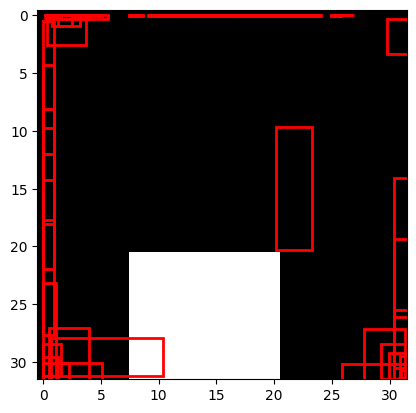

Box coordinates: xmin=23.1442813873291, ymin=8.109487533569336, xmax=26.36739730834961, ymax=23.858240127563477
Box coordinates: xmin=22.031240463256836, ymin=16.317350387573242, xmax=27.031278610229492, ymax=22.312519073486328
Box coordinates: xmin=21.982221603393555, ymin=8.528302192687988, xmax=24.91569709777832, ymax=25.055341720581055
Box coordinates: xmin=22.67218780517578, ymin=7.116636276245117, xmax=25.60377311706543, ymax=20.165075302124023
Box coordinates: xmin=20.242284774780273, ymin=17.404422760009766, xmax=25.727996826171875, ymax=21.32636833190918
Box coordinates: xmin=22.957609176635742, ymin=14.200562477111816, xmax=26.24458122253418, ymax=26.967939376831055
Box coordinates: xmin=11.468897819519043, ymin=30.966815948486328, xmax=13.819144248962402, ymax=32.0
Box coordinates: xmin=21.642030715942383, ymin=7.067423343658447, xmax=24.214921951293945, ymax=20.94698143005371
Box coordinates: xmin=21.763700485229492, ymin=12.397880554199219, xmax=23.23727035522461, ymax=18.

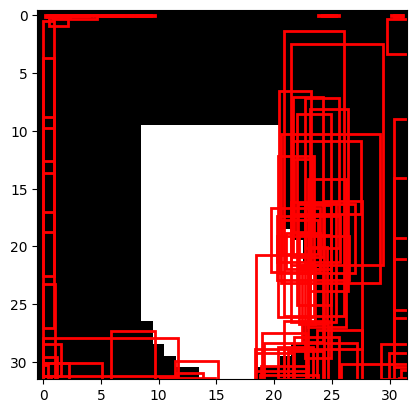

Box coordinates: xmin=20.531391143798828, ymin=2.973339796066284, xmax=23.801410675048828, ymax=17.4503231048584
Box coordinates: xmin=6.062235355377197, ymin=0.0, xmax=9.171341896057129, ymax=17.642316818237305
Box coordinates: xmin=5.718117713928223, ymin=7.828105449676514, xmax=10.64480209350586, ymax=13.784943580627441
Box coordinates: xmin=8.09575080871582, ymin=0.19699522852897644, xmax=10.96249771118164, ymax=12.655134201049805
Box coordinates: xmin=19.146238327026367, ymin=0.3669976592063904, xmax=21.928558349609375, ymax=12.480204582214355
Box coordinates: xmin=20.250391006469727, ymin=1.2756719589233398, xmax=23.123579025268555, ymax=12.555930137634277
Box coordinates: xmin=4.90562629699707, ymin=0.26068541407585144, xmax=7.899611473083496, ymax=16.603866577148438
Box coordinates: xmin=6.702950954437256, ymin=5.660817623138428, xmax=9.52011775970459, ymax=8.252331733703613
Box coordinates: xmin=19.089508056640625, ymin=4.959499359130859, xmax=22.938650131225586, ymax=16.68622

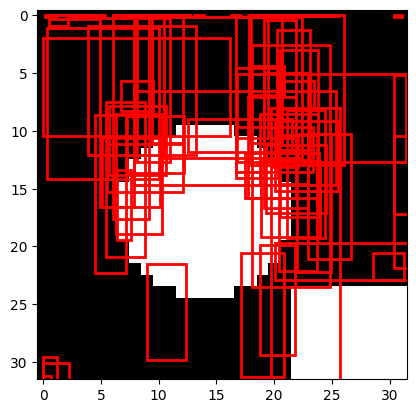

Box coordinates: xmin=0.0, ymin=30.079200744628906, xmax=5.1175217628479, ymax=31.915651321411133
Box coordinates: xmin=6.1187944412231445, ymin=12.223278999328613, xmax=9.498591423034668, ymax=23.003742218017578
Box coordinates: xmin=29.2579402923584, ymin=29.55016326904297, xmax=31.649127960205078, ymax=31.72047996520996
Box coordinates: xmin=0.0, ymin=28.40608024597168, xmax=1.530542254447937, ymax=31.25591468811035
Box coordinates: xmin=0.0, ymin=23.17174530029297, xmax=1.0785579681396484, ymax=31.79075813293457
Box coordinates: xmin=30.88897705078125, ymin=29.460371017456055, xmax=32.0, ymax=31.795013427734375
Box coordinates: xmin=0.7616990208625793, ymin=0.0, xmax=4.685694694519043, ymax=0.3299659192562103
Box coordinates: xmin=30.98884391784668, ymin=30.67170524597168, xmax=31.999059677124023, ymax=31.958200454711914
Box coordinates: xmin=0.0, ymin=30.05722427368164, xmax=2.223355770111084, ymax=31.92861557006836
Box coordinates: xmin=30.80577278137207, ymin=31.331552505493164,

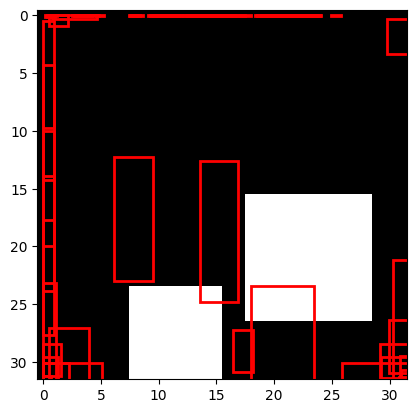

Box coordinates: xmin=6.81826639175415, ymin=6.860880374908447, xmax=9.60714054107666, ymax=22.34300422668457
Box coordinates: xmin=15.510892868041992, ymin=7.437692642211914, xmax=18.43816375732422, ymax=23.37348747253418
Box coordinates: xmin=5.73573112487793, ymin=8.09128189086914, xmax=8.522587776184082, ymax=23.15159034729004
Box coordinates: xmin=14.476835250854492, ymin=6.663900375366211, xmax=17.416067123413086, ymax=20.007850646972656
Box coordinates: xmin=16.389801025390625, ymin=8.116881370544434, xmax=19.362342834472656, ymax=20.266265869140625
Box coordinates: xmin=8.024602890014648, ymin=6.962962627410889, xmax=10.928983688354492, ymax=19.982093811035156
Box coordinates: xmin=15.982645988464355, ymin=11.880754470825195, xmax=19.104761123657227, ymax=27.482336044311523
Box coordinates: xmin=7.699217796325684, ymin=17.330549240112305, xmax=16.747095108032227, ymax=20.154212951660156
Box coordinates: xmin=17.434511184692383, ymin=10.39044189453125, xmax=20.540241241455078, y

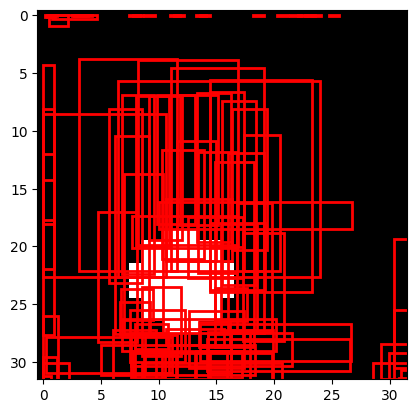

Box coordinates: xmin=12.744399070739746, ymin=0.0, xmax=15.602392196655273, ymax=9.94202995300293
Box coordinates: xmin=11.925700187683105, ymin=0.0, xmax=14.788007736206055, ymax=12.561283111572266
Box coordinates: xmin=11.17806625366211, ymin=4.445247650146484, xmax=16.61978530883789, ymax=10.95086669921875
Box coordinates: xmin=14.24402904510498, ymin=1.1076191663742065, xmax=15.776001930236816, ymax=5.895003318786621
Box coordinates: xmin=14.353726387023926, ymin=0.0, xmax=17.128551483154297, ymax=8.673724174499512
Box coordinates: xmin=25.87643051147461, ymin=1.1606539487838745, xmax=31.10595703125, ymax=7.074358940124512
Box coordinates: xmin=15.233233451843262, ymin=0.0, xmax=17.9013671875, ymax=6.085179328918457
Box coordinates: xmin=15.13531494140625, ymin=0.8678897023200989, xmax=16.641490936279297, ymax=5.888362884521484
Box coordinates: xmin=15.777379989624023, ymin=0.8154671788215637, xmax=17.308515548706055, ymax=5.300384521484375
Box coordinates: xmin=26.325056076049805

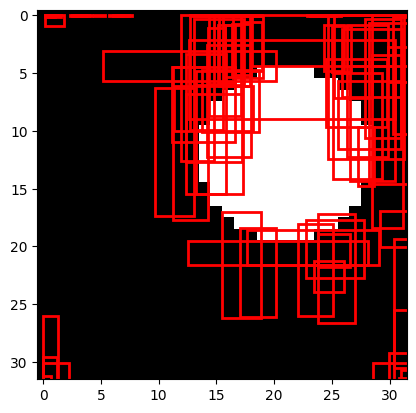

Box coordinates: xmin=12.333735466003418, ymin=14.373696327209473, xmax=16.095703125, ymax=23.39198875427246
Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=30.909311294555664, ymin=29.448286056518555, xmax=32.0, ymax=31.799530029296875
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=31.009904861450195, ymin=30.67877197265625, xmax=32.0, ymax=31.958209991455078
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884658813, ymax=31.80974578857422
Box coordinates: xmin=0.0, ymin=27.865673065185547, xmax=10.369638442993164, ymax=30.916616439819336
Box coordinates: xmin=0.7616990208625793, ymin=0.0, xmax=4.685694694519043, ymax=0.3299659192562103
Box coordinates: xmin=0.1664239466190338, ymin=16.16033935546875, xmax=15.81508731842041, ymax=19.060224533081055
Box coordinates: xmin=30.820173263549805, ymin=31.352304458618164, xmax=32

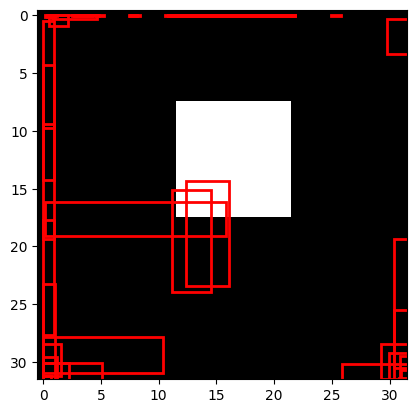

Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=16.311634063720703, ymin=3.4986088275909424, xmax=19.556596755981445, ymax=13.754369735717773
Box coordinates: xmin=13.862528800964355, ymin=27.24144744873047, xmax=17.44087028503418, ymax=31.93337631225586
Box coordinates: xmin=30.34827995300293, ymin=4.066103935241699, xmax=32.0, ymax=15.99980640411377
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884658813, ymax=31.80974578857422
Box coordinates: xmin=0.0, ymin=27.865447998046875, xmax=10.368847846984863, ymax=30.916351318359375
Box coordinates: xmin=0.7616990208625793, ymin=0.0, xmax=4.685694694519043, ymax=0.3299659192562103
Box coordinates: xmin=0.0, ymin=30.06357765197754, xmax=2.2150769233703613, ymax=31.929534912109375
Box coordinates: xmin=0.0, ymin=31.2222957611084, xmax=0.705739259719848

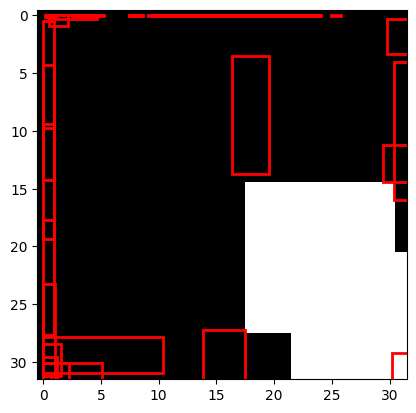

Box coordinates: xmin=30.33428382873535, ymin=9.431676864624023, xmax=32.0, ymax=19.64687156677246
Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=18.35157012939453, ymin=27.08713150024414, xmax=21.851600646972656, ymax=31.946237564086914
Box coordinates: xmin=20.156343460083008, ymin=3.40476131439209, xmax=23.373720169067383, ymax=13.895766258239746
Box coordinates: xmin=21.395544052124023, ymin=24.18474006652832, xmax=24.949514389038086, ymax=30.300559997558594
Box coordinates: xmin=17.01680564880371, ymin=27.25827980041504, xmax=20.60892105102539, ymax=31.910429000854492
Box coordinates: xmin=30.866886138916016, ymin=11.503981590270996, xmax=32.0, ymax=13.945871353149414
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884658813, ymax=31.80974578857422
Box coordinates: xmin=0.0, ymin=27.865673065

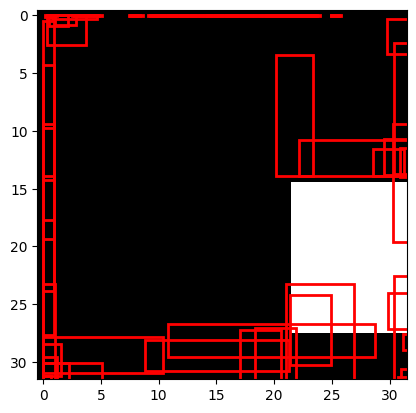

Box coordinates: xmin=5.491778373718262, ymin=11.547290802001953, xmax=10.443361282348633, ymax=17.730215072631836
Box coordinates: xmin=5.949703693389893, ymin=3.1632518768310547, xmax=9.15894603729248, ymax=20.6717529296875
Box coordinates: xmin=22.879018783569336, ymin=10.343194007873535, xmax=27.966121673583984, ymax=16.333284378051758
Box coordinates: xmin=7.098477840423584, ymin=2.6318469047546387, xmax=9.805883407592773, ymax=16.910825729370117
Box coordinates: xmin=8.058589935302734, ymin=1.8876214027404785, xmax=10.992562294006348, ymax=16.717594146728516
Box coordinates: xmin=24.33212661743164, ymin=4.717922687530518, xmax=27.66956329345703, ymax=21.05010414123535
Box coordinates: xmin=4.791057586669922, ymin=3.3489561080932617, xmax=7.88704776763916, ymax=20.244722366333008
Box coordinates: xmin=10.775160789489746, ymin=1.875535249710083, xmax=13.665031433105469, ymax=14.344216346740723
Box coordinates: xmin=9.397045135498047, ymin=1.347634196281433, xmax=12.319259643554688,

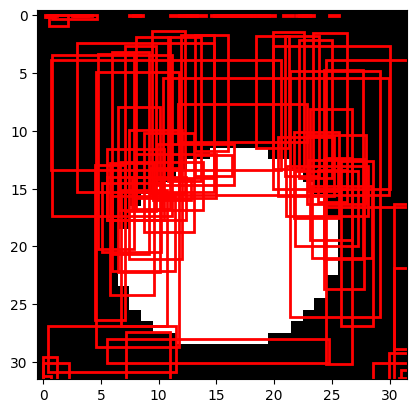

Box coordinates: xmin=1.3034645318984985, ymin=0.16389159858226776, xmax=6.251247406005859, ymax=5.132108688354492
Box coordinates: xmin=0.0, ymin=0.0, xmax=9.57882022857666, ymax=4.393036365509033
Box coordinates: xmin=0.3569495975971222, ymin=0.14932586252689362, xmax=3.6965794563293457, ymax=8.682557106018066
Box coordinates: xmin=11.926156997680664, ymin=0.0, xmax=14.874516487121582, ymax=2.9531211853027344
Box coordinates: xmin=4.295891761779785, ymin=0.0, xmax=7.391889572143555, ymax=2.678554058074951
Box coordinates: xmin=13.564772605895996, ymin=10.262831687927246, xmax=24.530433654785156, ymax=13.894318580627441
Box coordinates: xmin=12.55561637878418, ymin=3.9405174255371094, xmax=18.08656120300293, ymax=9.791818618774414
Box coordinates: xmin=13.076464653015137, ymin=0.0, xmax=16.221982955932617, ymax=2.9594035148620605
Box coordinates: xmin=2.234722137451172, ymin=0.0, xmax=5.615567684173584, ymax=2.738581418991089
Box coordinates: xmin=10.664915084838867, ymin=0.0, xmax=13

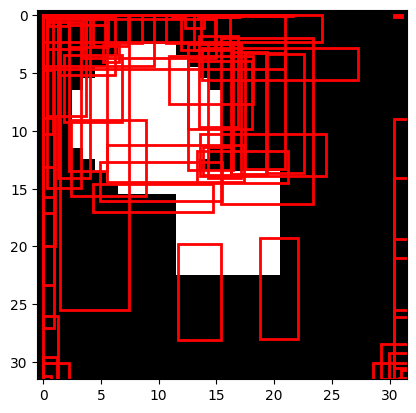

Box coordinates: xmin=7.537744045257568, ymin=1.4069567918777466, xmax=12.111019134521484, ymax=7.173870086669922
Box coordinates: xmin=7.505129814147949, ymin=0.0, xmax=10.510507583618164, ymax=10.366525650024414
Box coordinates: xmin=8.61875057220459, ymin=0.0, xmax=11.413240432739258, ymax=8.189790725708008
Box coordinates: xmin=6.432826995849609, ymin=0.0, xmax=9.426801681518555, ymax=10.743453979492188
Box coordinates: xmin=22.838146209716797, ymin=1.3687047958374023, xmax=28.175949096679688, ymax=7.535267353057861
Box coordinates: xmin=22.548725128173828, ymin=4.651390552520752, xmax=27.64141082763672, ymax=11.087220191955566
Box coordinates: xmin=5.533836364746094, ymin=1.37702476978302, xmax=10.552122116088867, ymax=7.366412162780762
Box coordinates: xmin=24.97730255126953, ymin=0.0, xmax=28.185598373413086, ymax=10.257094383239746
Box coordinates: xmin=7.264553070068359, ymin=4.8044586181640625, xmax=12.058276176452637, ymax=10.894392013549805
Box coordinates: xmin=23.79584693

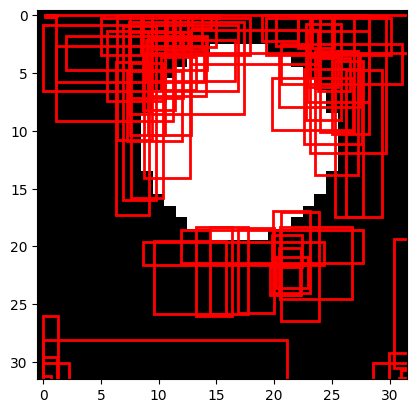

Box coordinates: xmin=1.2654625177383423, ymin=0.3318435549736023, xmax=6.2123541831970215, ymax=6.138966083526611
Box coordinates: xmin=0.34743207693099976, ymin=0.02809906005859375, xmax=3.8301947116851807, ymax=8.829567909240723
Box coordinates: xmin=4.725924015045166, ymin=13.10338306427002, xmax=11.015528678894043, ymax=17.850107192993164
Box coordinates: xmin=12.313336372375488, ymin=1.3557803630828857, xmax=15.565155029296875, ymax=10.896408081054688
Box coordinates: xmin=2.3713555335998535, ymin=6.21397066116333, xmax=3.570160388946533, ymax=7.473036766052246
Box coordinates: xmin=11.151799201965332, ymin=0.0, xmax=14.09035587310791, ymax=7.181293964385986
Box coordinates: xmin=5.948309421539307, ymin=10.8108491897583, xmax=10.034491539001465, ymax=17.950302124023438
Box coordinates: xmin=10.229978561401367, ymin=11.59609603881836, xmax=13.585803985595703, ymax=19.585474014282227
Box coordinates: xmin=11.766894340515137, ymin=15.600801467895508, xmax=13.599306106567383, ymax=19

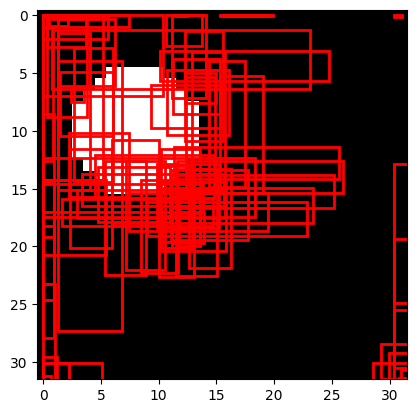

Box coordinates: xmin=0.0, ymin=30.08637046813965, xmax=5.117529392242432, ymax=31.926658630371094
Box coordinates: xmin=22.645511627197266, ymin=11.692527770996094, xmax=26.028968811035156, ymax=20.617015838623047
Box coordinates: xmin=12.7789888381958, ymin=13.414228439331055, xmax=27.467103958129883, ymax=16.601579666137695
Box coordinates: xmin=30.909311294555664, ymin=29.448286056518555, xmax=32.0, ymax=31.799530029296875
Box coordinates: xmin=0.0, ymin=28.408037185668945, xmax=1.5104552507400513, ymax=31.25119972229004
Box coordinates: xmin=31.009904861450195, ymin=30.67877197265625, xmax=32.0, ymax=31.958209991455078
Box coordinates: xmin=19.49887466430664, ymin=12.37053394317627, xmax=22.807838439941406, ymax=20.995973587036133
Box coordinates: xmin=0.0, ymin=23.216068267822266, xmax=1.0629268884658813, ymax=31.80974578857422
Box coordinates: xmin=1.5271121263504028, ymin=0.0, xmax=5.626781940460205, ymax=0.33213526010513306
Box coordinates: xmin=0.0, ymin=27.865673065185547, x

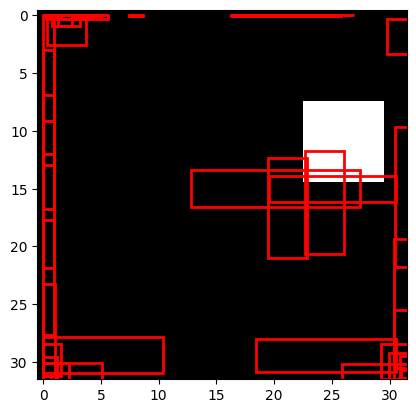

Box coordinates: xmin=13.143946647644043, ymin=4.092327117919922, xmax=16.153518676757812, ymax=17.77099609375
Box coordinates: xmin=4.83259391784668, ymin=3.6362035274505615, xmax=7.753438472747803, ymax=19.152074813842773
Box coordinates: xmin=12.011422157287598, ymin=4.226684093475342, xmax=14.846912384033203, ymax=17.086793899536133
Box coordinates: xmin=14.430720329284668, ymin=3.2058258056640625, xmax=17.33796501159668, ymax=18.834598541259766
Box coordinates: xmin=6.205751419067383, ymin=4.000759124755859, xmax=9.013516426086426, ymax=17.128551483154297
Box coordinates: xmin=9.509867668151855, ymin=21.443767547607422, xmax=13.20949935913086, ymax=29.693761825561523
Box coordinates: xmin=7.475594520568848, ymin=23.126508712768555, xmax=12.373793601989746, ymax=27.42757225036621
Box coordinates: xmin=15.57271957397461, ymin=3.930718183517456, xmax=18.34779167175293, ymax=18.21314239501953
Box coordinates: xmin=8.824556350708008, ymin=12.23271369934082, xmax=24.788227081298828, yma

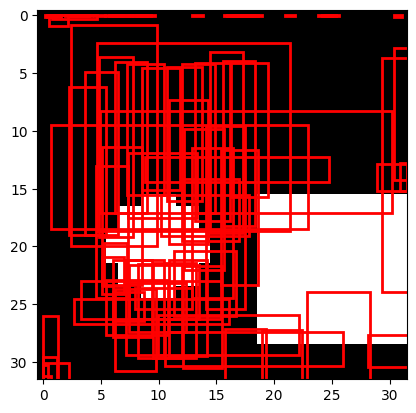

Box coordinates: xmin=15.167668342590332, ymin=4.179451942443848, xmax=18.120834350585938, ymax=17.18431282043457
Box coordinates: xmin=13.847587585449219, ymin=3.2584729194641113, xmax=16.886438369750977, ymax=15.972322463989258
Box coordinates: xmin=0.685162365436554, ymin=4.389853477478027, xmax=3.953599214553833, ymax=19.844554901123047
Box coordinates: xmin=0.9079026579856873, ymin=8.049160957336426, xmax=5.952225685119629, ymax=14.499224662780762
Box coordinates: xmin=12.56163215637207, ymin=2.2857489585876465, xmax=15.471529006958008, ymax=15.125524520874023
Box coordinates: xmin=12.211862564086914, ymin=8.340337753295898, xmax=15.943459510803223, ymax=18.088010787963867
Box coordinates: xmin=13.242263793945312, ymin=11.56725025177002, xmax=17.21608543395996, ymax=20.05261993408203
Box coordinates: xmin=2.1577160358428955, ymin=2.852118492126465, xmax=5.263911724090576, ymax=16.77099609375
Box coordinates: xmin=5.489078998565674, ymin=1.5397814512252808, xmax=8.357504844665527, 

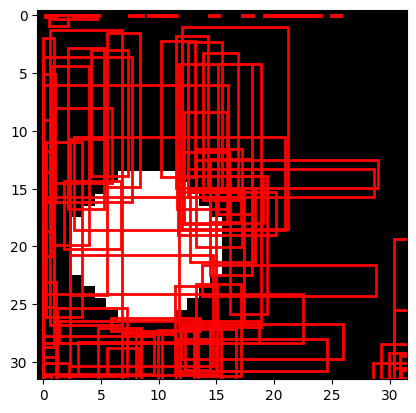

Box coordinates: xmin=9.730466842651367, ymin=0.0, xmax=12.28632640838623, ymax=6.356261253356934
Box coordinates: xmin=10.337958335876465, ymin=0.7898154854774475, xmax=11.862829208374023, ymax=5.261381149291992
Box coordinates: xmin=11.242633819580078, ymin=0.7417658567428589, xmax=12.883817672729492, ymax=4.839070796966553
Box coordinates: xmin=19.030536651611328, ymin=0.0, xmax=21.64655876159668, ymax=6.220007419586182
Box coordinates: xmin=17.826406478881836, ymin=0.0, xmax=20.32068634033203, ymax=6.053639888763428
Box coordinates: xmin=10.768333435058594, ymin=0.0, xmax=13.434004783630371, ymax=6.003452777862549
Box coordinates: xmin=10.220924377441406, ymin=8.460485458374023, xmax=12.486947059631348, ymax=11.681884765625
Box coordinates: xmin=17.17656135559082, ymin=3.1733226776123047, xmax=21.62134552001953, ymax=8.586682319641113
Box coordinates: xmin=9.436605453491211, ymin=1.4037810564041138, xmax=12.320534706115723, ymax=11.701303482055664
Box coordinates: xmin=13.360658645

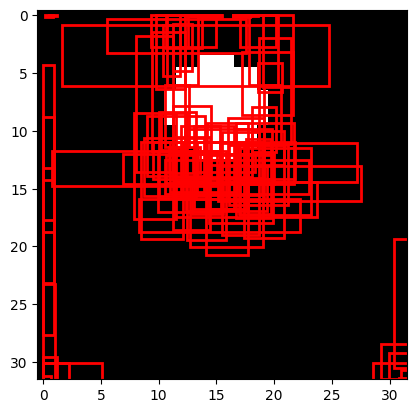

Box coordinates: xmin=16.0587100982666, ymin=6.6703948974609375, xmax=19.267072677612305, ymax=20.167741775512695
Box coordinates: xmin=7.484704494476318, ymin=4.075886249542236, xmax=10.206551551818848, ymax=19.20458984375
Box coordinates: xmin=17.00019645690918, ymin=4.795539379119873, xmax=19.845592498779297, ymax=18.786542892456055
Box coordinates: xmin=8.419537544250488, ymin=5.713474750518799, xmax=11.591242790222168, ymax=20.22972869873047
Box coordinates: xmin=9.280972480773926, ymin=4.30739164352417, xmax=12.117162704467773, ymax=17.49761199951172
Box coordinates: xmin=15.12188720703125, ymin=4.560423374176025, xmax=18.091102600097656, ymax=17.015411376953125
Box coordinates: xmin=18.153644561767578, ymin=6.430271625518799, xmax=21.31539535522461, ymax=18.559412002563477
Box coordinates: xmin=6.4080047607421875, ymin=5.307170391082764, xmax=9.31042194366455, ymax=19.235626220703125
Box coordinates: xmin=16.815200805664062, ymin=10.685922622680664, xmax=19.788494110107422, ymax

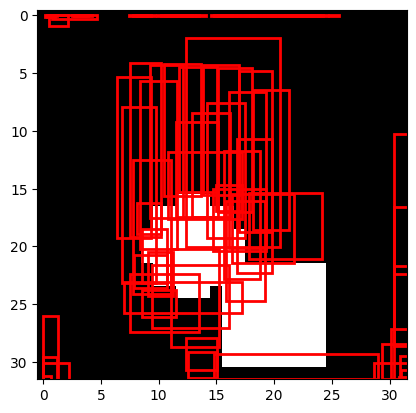

Box coordinates: xmin=19.442481994628906, ymin=1.2849230766296387, xmax=22.219675064086914, ymax=14.176475524902344
Box coordinates: xmin=9.353753089904785, ymin=0.6278765797615051, xmax=11.998211860656738, ymax=14.859281539916992
Box coordinates: xmin=18.37548065185547, ymin=0.13675719499588013, xmax=21.144344329833984, ymax=14.263395309448242
Box coordinates: xmin=10.475251197814941, ymin=0.4016937017440796, xmax=13.397138595581055, ymax=14.915082931518555
Box coordinates: xmin=8.294975280761719, ymin=1.711076021194458, xmax=11.008183479309082, ymax=14.288519859313965
Box coordinates: xmin=20.674476623535156, ymin=3.200342893600464, xmax=23.738061904907227, ymax=13.457768440246582
Box coordinates: xmin=17.051111221313477, ymin=0.7572289705276489, xmax=19.990732192993164, ymax=14.164875030517578
Box coordinates: xmin=11.866400718688965, ymin=1.5659936666488647, xmax=14.557401657104492, ymax=13.21070384979248
Box coordinates: xmin=18.668210983276367, ymin=3.0043230056762695, xmax=21.74

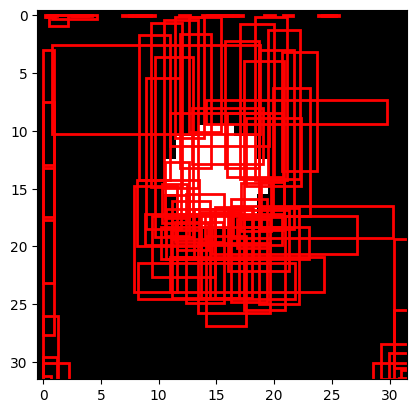

Box coordinates: xmin=20.5811767578125, ymin=3.743136405944824, xmax=23.57770538330078, ymax=19.487857818603516
Box coordinates: xmin=11.256970405578613, ymin=3.4666173458099365, xmax=14.0700044631958, ymax=18.701616287231445
Box coordinates: xmin=12.260181427001953, ymin=4.262829303741455, xmax=15.324849128723145, ymax=19.25891876220703
Box coordinates: xmin=14.5205659866333, ymin=13.4564790725708, xmax=23.31444549560547, ymax=16.39379119873047
Box coordinates: xmin=19.318971633911133, ymin=4.01766300201416, xmax=22.51083755493164, ymax=19.506847381591797
Box coordinates: xmin=22.034765243530273, ymin=5.096998691558838, xmax=25.14717674255371, ymax=17.280420303344727
Box coordinates: xmin=10.11953353881836, ymin=5.276811599731445, xmax=13.00564193725586, ymax=19.255285263061523
Box coordinates: xmin=13.176668167114258, ymin=3.157449245452881, xmax=16.006710052490234, ymax=16.122018814086914
Box coordinates: xmin=14.315102577209473, ymin=4.826836585998535, xmax=17.217121124267578, ymax

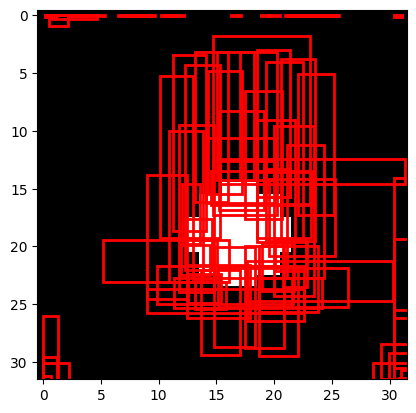

KeyboardInterrupt: 

In [34]:
# Функция для вывода ограничивающих рамок на изображении
def plot_boxes(image, boxes):
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        print(f"Box coordinates: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")
    plt.show()

model.eval()

for images, _ in test_loader:
    with torch.no_grad():
        prediction = model(images)


    boxes = prediction[0]['boxes'][prediction[0]['labels'] == 1].tolist()

    image = T.ToPILImage()(images.squeeze(0))
    plot_boxes(image, boxes)